# Outline
1. Read in Data
2. Count Vectorize
3. Genism
4. Initial Dimensionality Reductions
5. Initial Clustering
6. Pipeline for steps 2-4
7. ID Most reasonable cluster
8. Employ Said Cluster
9. Explore Outcomes

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pickle
import pandas as pd

In [2]:
with open('final.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,username,eye_color,hair,skin_tone,skin_type,skin_concerns,foundation_color,review,recommend,unhelpful,helpful,star
0,creecreex,Brown,Brunette,Deep,Normal,Cellulite,370,I have 370 and I got matched at Sephora. I lik...,1,0,14,100
1,Jijine,Brown,Black,Dark,Combination,Unknown,470,It is like my skin but better. very lightweigh...,1,0,5,100
2,bloodyblondie,Blue,Black,Porcelain,Dry,Blackheads,100,I was so nervous about trying this product bec...,1,0,5,100
3,miralanani,Brown,Brunette,Medium,Combination,Acne,270,This product was amazing! Just fell in love! T...,1,0,5,100
4,shaaliyah,Brown,Black,Deep,Combination,Acne,370,Since purchasing this foundation it's been my ...,1,0,38,100


# Count Vectorize

In [4]:
from gensim import corpora, models, similarities, matutils
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import logging

In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', max_df=0.6, token_pattern="\\b[a-z][a-z]+\\b")

In [6]:
cv_data=count_vectorizer.fit_transform(df['review'])

In [7]:
cv_as_array= count_vectorizer.fit_transform(df['review']).toarray()

In [ ]:
dt=pd.DataFrame(cv_as_array, columns=count_vectorizer.get_feature_names())

In [ ]:
dt

In [8]:
count_vectorizer.fit(df['review'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
counts = count_vectorizer.transform(df['review']).transpose()

In [ ]:
counts.shape

In [10]:
corpus = matutils.Sparse2Corpus(counts)

In [11]:
id2word = { identifier: word for word, identifier in count_vectorizer.vocabulary_.items()}

In [ ]:
len(id2word)

# LDA

In [12]:
lda = models.LdaModel(corpus=corpus, num_topics=10, minimum_probability=0.03, id2word=id2word, passes=100)

In [ ]:
lda.print_topics()

# NMF / SVD

In [13]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [14]:
from sklearn.decomposition import NMF, TruncatedSVD

In [15]:
n_comp = 20
lsa_tfidf = TruncatedSVD(n_components=n_comp)

lsa_tfidf_data = lsa_tfidf.fit_transform(cv_data)

In [ ]:
display_topics(lsa_tfidf,count_vectorizer.get_feature_names(),10)

# Clustering

In [16]:
n_comp  =  40

lsa_cv = TruncatedSVD(n_components=n_comp)
lsa_cv_data = lsa_cv.fit_transform(cv_data)

lsa_cv_data.shape

(2657, 40)

In [17]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30.0)
lsa_cv_sne = tsne.fit_transform(lsa_cv_data)

In [18]:
import matplotlib.pyplot as plt

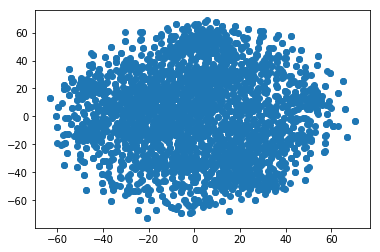

In [19]:
plt.plot(lsa_cv_sne[:, 0], lsa_cv_sne[:, 1],'o')

In [20]:
from sklearn.metrics import silhouette_score

SSEs = []
Sil_coefs = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 


inertia = [0,0]

for n_clusters in range(2, 25):
    km = KMeans(n_clusters = n_clusters)
    km.fit(lsa_cv_data)
    msg = f"""# clusters: {n_clusters:2d}   Inertia: {km.inertia_:8.6f}"""
    inertia.append(km.inertia_)
    print(msg)

# clusters:  2   Inertia: 36005.976249
# clusters:  3   Inertia: 35049.566383
# clusters:  4   Inertia: 34238.998019
# clusters:  5   Inertia: 33573.043660
# clusters:  6   Inertia: 32841.670652
# clusters:  7   Inertia: 32398.315073
# clusters:  8   Inertia: 31747.338217
# clusters:  9   Inertia: 31447.564233
# clusters: 10   Inertia: 30884.938974
# clusters: 11   Inertia: 30633.306471
# clusters: 12   Inertia: 30051.923155
# clusters: 13   Inertia: 29961.408659
# clusters: 14   Inertia: 29317.472108
# clusters: 15   Inertia: 29032.604579
# clusters: 16   Inertia: 28892.959858
# clusters: 17   Inertia: 28482.395721
# clusters: 18   Inertia: 28245.566435
# clusters: 19   Inertia: 28021.448693
# clusters: 20   Inertia: 27804.173730
# clusters: 21   Inertia: 27520.029846
# clusters: 22   Inertia: 27340.814818
# clusters: 23   Inertia: 27053.415039
# clusters: 24   Inertia: 26960.134231


Text(0.5,1,'SSE By Cluster')

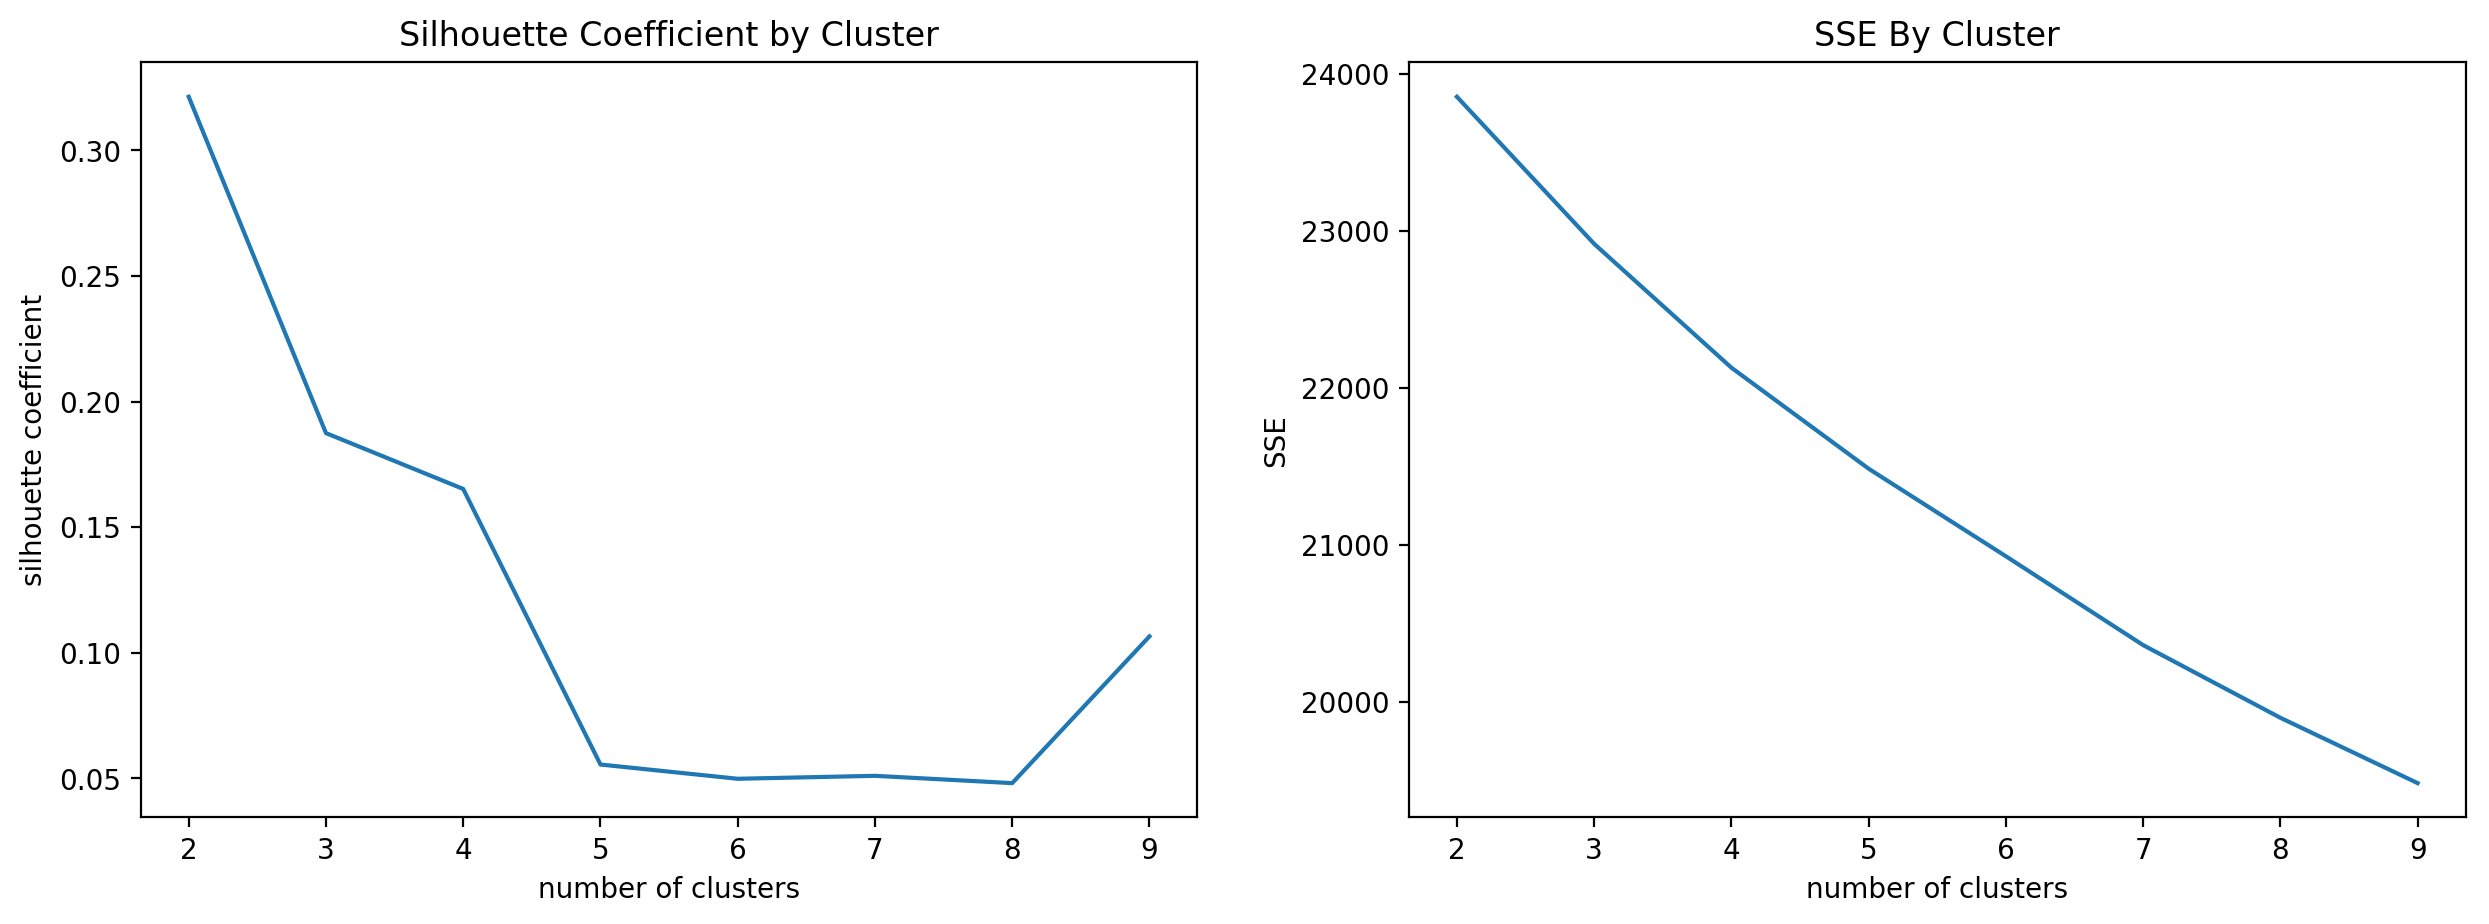

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(2,10)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_title('Silhouette Coefficient by Cluster')
# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE')
ax2.set_title('SSE By Cluster')

Text(0.5,1,'Inertia by Cluster')

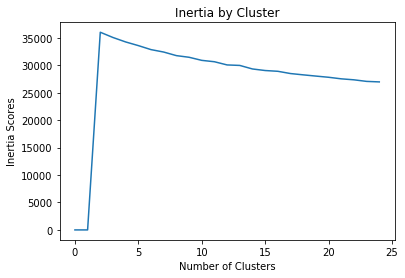

In [22]:
plt.plot(inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Scores')
plt.title("Inertia by Cluster")
# plt.xlim((2,25))
# plt.ylim((50000,400000))

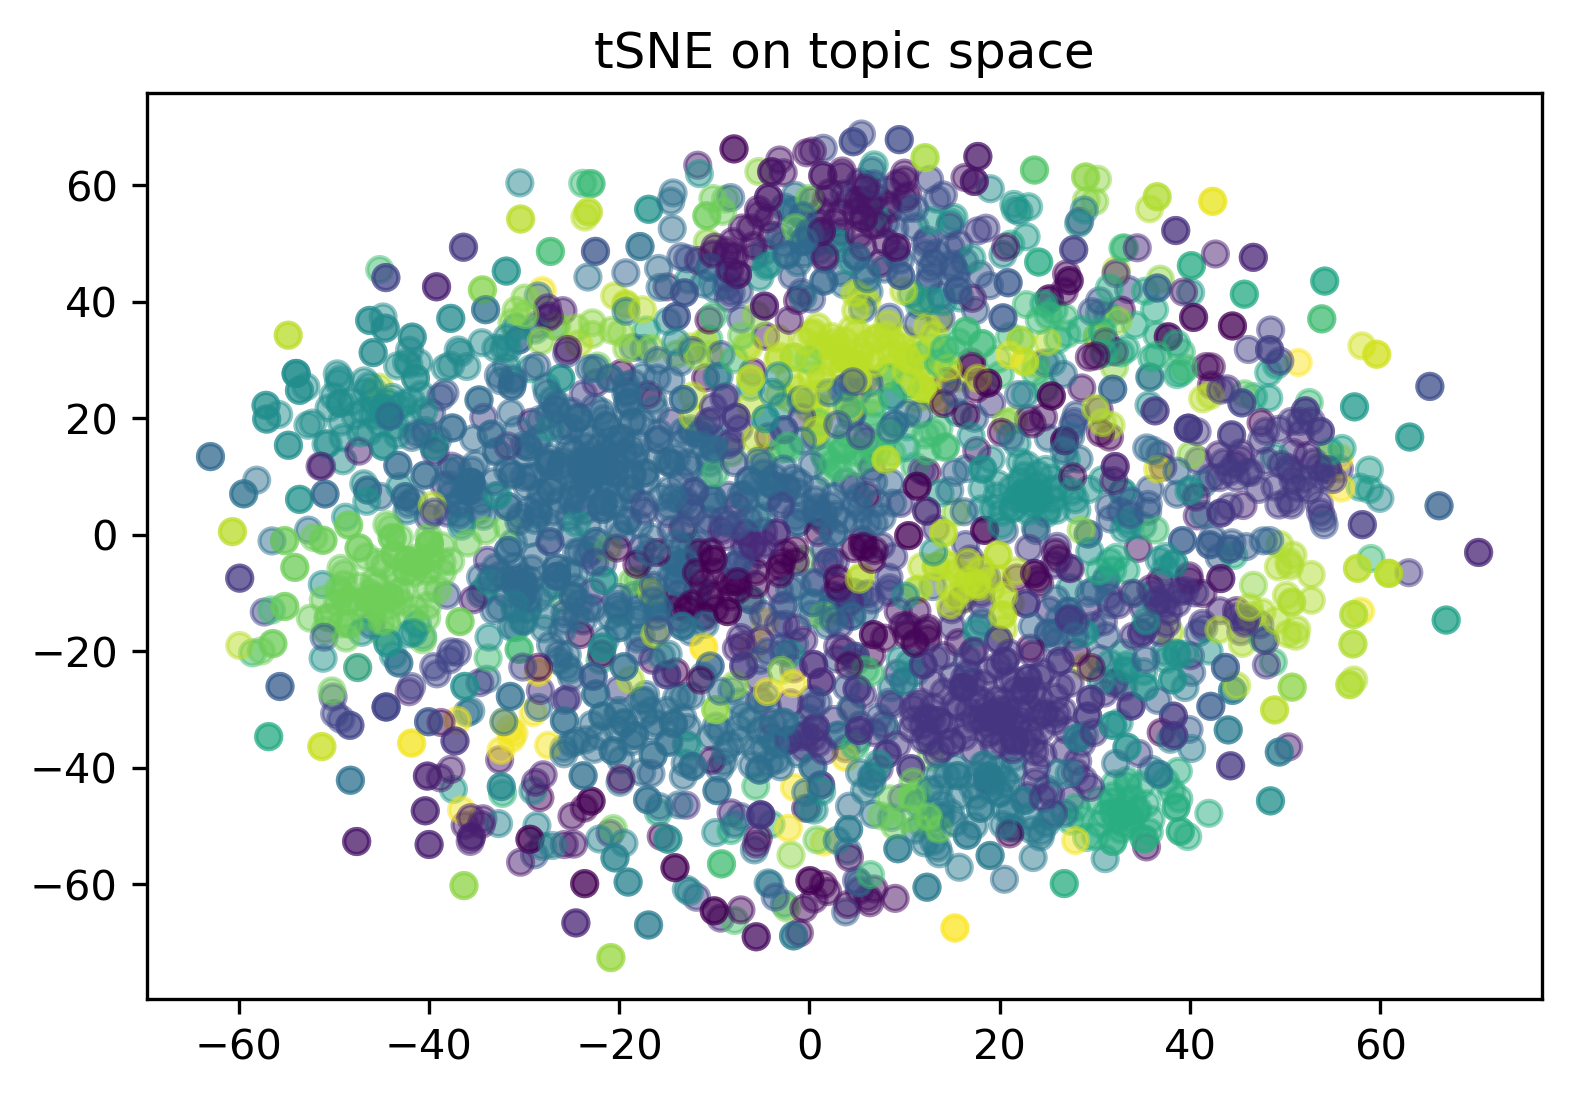

In [23]:
plt.figure(dpi=300)

n_clusters = 60
km = KMeans(n_clusters = n_clusters)
km.fit(lsa_cv_data)
    
plt.scatter(lsa_cv_sne[:, 0], lsa_cv_sne[:, 1],c=km.labels_, alpha=0.5)
plt.title('tSNE on topic space');

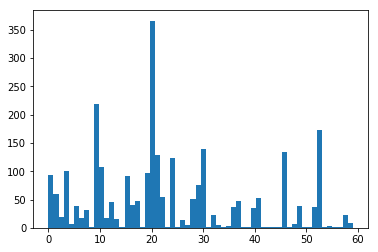

In [31]:
plt.hist(km.labels_, bins=n_clusters);

# Repeating with Modifiable Pipeline

In [29]:
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler
from itertools import cycle

In [30]:
class clustering_pipeline:
    def __init__(self, vectorizer, n_components, reducer):
        self.vectorizer = vectorizer
        self.n_dim = n_components
        self.reducer = reducer(n_components)
        
    def fit(self, text):
        self.vectorizer.fit(text)
        self.vector_data = self.vectorizer.fit_transform(text)
        self.topic_data = self.reducer.fit_transform(self.vector_data)
        self.texts = text

    def tsne(self, n_components, perplexity):
        tsne = TSNE(n_components = n_components, perplexity = perplexity)
        plt.figure(dpi=300)
        vector_tsne = tsne.fit_transform(self.topic_data)
        plt.scatter(vector_tsne[:, 0], vector_tsne[:, 1],c=self.labels_, alpha=0.5)
        plt.title(f'tSNE on topic space using {self.cluster_method}');
        plt.figure(dpi=300)
        plt.hist(self.labels_, bins=self.n_clusters);
        
    def kmeans(self, n_clusters):
        self.km = KMeans(n_clusters=n_clusters)
        self.labels_ = self.km.fit_predict(self.topic_data)
        self.cluster_method='kmeans'
        self.n_clusters=n_clusters
        self.cluster_centers=self.km.cluster_centers_
        
    def db(self, eps, min_samples):
        self.db = DBSCAN(eps=eps, min_samples=min_samples).fit(self.topic_data)
        core_samples_mask = np.zeros_like(self.db.labels_, dtype=bool)
        core_samples_mask[self.db.core_sample_indices_] = True
        self.labels_ = self.db.labels_
        self.cluster_method='db'
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        self.n_clusters=n_clusters

    def spectral(self, article, num_to_return, n_clusters):
        self.sc = SpectralClustering(n_clusters=n_clusters)
        self.labels_ = self.sc.fit_predict(self.topic_data)
        self.cluster_method='spectral'
        self.n_clusters=n_clusters
        
    def meanshift(self, quantile, n_samples):
        bandwidth = estimate_bandwidth(self.x, quantile=quantile, n_samples=n_samples)
        self.ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        self.ms.fit(self.topic_data)
        self.labels_ = self.ms.labels_
        self.cluster_method = 'meanshift'
        self.cluster_centers = self.ms.cluster_centers_

        labels_unique = np.unique(self.labels_)
        self.n_clusters_ = len(labels_unique)

        print("number of estimated clusters : %d" % n_clusters_)

        result_texts = [self.texts[i] for i in results[1][0]]
        
        return result_texts

# Identifying Most Reasonable Cluster

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [52]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / np.sqrt(np.dot(vec1, vec1) * np.dot(vec2, vec2))

def best_cluster(cluster):
    overall_clusters=[]
    for number in set(cluster.labels_):
        cluster_center = cluster.km.cluster_centers_[number]
        distances=[]
        for index, vector in enumerate(cluster.topic_data):
            dist = cosine_similarity(cluster_center,vector)
            distances.append((dist, index))
        distances.sort()
        indices=[x[1] for x in distances[-4:]]
        print( f"\n + {distances[-4:]}")
        for i in indices:
            print("\n" + df.review.iloc[i])

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [36]:
def making_vectorizers(data):
    count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
    tfidf_vectorizer =TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
    one=clustering_pipeline(count_vectorizer, n_components = 20, reducer = TruncatedSVD)
    one.fit(data)
    two=clustering_pipeline(tfidf_vectorizer, n_components = 20, reducer = TruncatedSVD)
    two.fit(data)
    return (one, two)

In [37]:
(one, two)= making_vectorizers(df.review)

In [38]:
def many_kmeans(cluster, n_clusters):
    for i in range(1, n_clusters+1):
        cluster.kmeans(i)
        best_cluster(cluster)
        print('\n'+'-------------------------------------NEXT CLUSTER -------------------------------------------')

In [46]:
one.kmeans(10)

In [40]:
one.db(eps=0.15, min_samples=3)

In [55]:
many_kmeans(one, 10)


 + [(0.8067015620156174, 228), (0.810106982240513, 260), (0.8104269782393912, 339), (0.8224598716012442, 72)]

This line offers many shades and makes it super easy to get a perfect color match! Tbh the formula wasn't my favorite. I really wanted to love this foundation because it feels super light weight on the skin and offers decent coverage. Unfortunately, I have very oily/combination skin and this separates terribly on my more oily areas within 2 hours of me wearing it. With my experience with this product and while working with it on clients today, I feel like it works best if you have a dry/normal skin type. It is water based so it does perform better with a waters based primer. I would definitely wear it again to give it another try but it isn't a holy grail and it isn't a favorite either.

I have this foundation in 410. I originally bought 420, but it was too orange. I have dark skin with golden undertones. You really must go in store to match. It is going to be extremely diffi


 + [(0.8135573036788938, 202), (0.81782610837431, 2537), (0.8253279377247573, 1810), (0.8424804517577306, 260)]

So, the first time I got matched by a sephora rep, she swatched my cheek, let it dry down and i bought it. I should've known better because I have hyperpigmentation around my mouth and also neat mt jawline. The center of my face is lighter than my neck and chest. The foundation came out ashy all over when I put a full face on (420). I went back and tried 450 all over. It's not PERFECT match but it covers everything. If there was a warm shade between 440 and 450, that would be me but I can definitely get away with it by doing a little highlighting. Overall, it literally covers everything , didnt need to prime or set OR conceal. Mind you, I have combination oily skin and my forehead gets especially shiny. I have some hyperpigmentation like I said but I don't have many blemishes and my skin doesn't have a lot of texture so I don't know how it pans out on other types aside from


 + [(0.7897857394675292, 679), (0.7932682913621414, 1810), (0.8119820103873459, 72), (0.8160954543336448, 226)]

I am in love with this foundation. Literally feels like I don’t even have makeup on but makes my face look flawless. The finish looks soft and velvety and just perfect. I would say this foundation is medium coverage, but buildable. Also great for my oily skin. My new favorite! Rihanna slayed with this foundation.

I LOVE THIS FOUNDATION! When I wear it it is a very nice matte. Not overly matte or too dewy. It makes my skin look like a better version of itself. I was kind of hesitant to try it, but I got a color match in Sephora and 160 blended really perfectly into my skin tone. Usually I have more yellow undertones when it comes to foundation, and in this description it says it has a peachy undertone but I don't think it's too peachy, only the slightest in my opinion. With one application total my face was medium coverage, and I builded it up for full coverage. I did not e


 + [(0.8824879977844312, 1923), (0.8847849618197019, 181), (0.8895505183531279, 2347), (0.9107134607835917, 310)]

I love this foundation. I got it as a sample with a previous order and fell in love with it and wanted to try it. It is veryyyyy long wearing, in my experience. It lasted me about 10 hours without any touch ups or anything and looked great. works well with my Tarte Shape Tape concealer and my Laura Mercier powder. It is very full coverage but does not feel heavy or look cakey. This has become my go-to foundation and definitely a new favorite.

I love love love this product. I tend to prefer light coverage to medium coverage foundations, and this fit the bill perfectly. It's very light and semi matte, which I absolutely love. No setting is necessary; as it dries quickly. I applied with the Sephora #47 foundation brush and thought that it went on perfectly. Beware of the dry down...I was lucky in that I swatched three shades in store and was able to match from there, but th


 + [(0.8078601187917263, 260), (0.8163892122319545, 121), (0.8206882175506884, 2262), (0.8304549455928621, 339)]

I have this foundation in 410. I originally bought 420, but it was too orange. I have dark skin with golden undertones. You really must go in store to match. It is going to be extremely difficult to pick a color from online swatches. I really like this foundation. I'm amazed at how matte it is and remains throughout the day. I am oily and after 4 hours of wear, I still don't need to blot. It's the first foundation that makes me think I can get away without setting it with powder (I do, of course!). The very thin formula makes it very lightweight and capable of building up to fuller coverage and still look like skin. It will cling to dry patches so you may want to avoid if you have dry skin, or be sure to moisturize and prime with hydrating primer before application. And finally, I can't not mention the fact that Rihanna released 40 shades! Incredible and unheard of. Brava,


 + [(0.8403979435315727, 665), (0.8461938490157822, 95), (0.8496755735953152, 2262), (0.8608312938418848, 705)]

so i went into my sephora in jcp today and everything was in stock even the dark shades. at first i wasnt here for the line because it more focuses on skin and i love eyes and lips more. but fenty beauty has changed everything for me! ive never been excited about foundation until today because i match not only one shade but two shades! both 490 and 480 match me right now which is amazing because i have room to grow fpr the winter when i get lighter. i have never had this before and i can totally say i agree with cancelling everyone else who doesnt have my shade. it feels amazing to be included for once and actually look forward to applying my base. i cannot speak to the wear and functionality of the foundation yet as my order has not shipped yet (i ordered before visiting sephora) but looking at how matte it is on my sister today i can def say i like that. will update when 


 + [(0.8822750124414277, 97), (0.8950532965367988, 164), (0.8977156345016944, 132), (0.9028953674951307, 2232)]

STOP WHAT YOU'RE DOING AND BUY THIS FOUNDATION. I went the store to try it on the day it came out and I was blown away. I have dry skin and I have issues with dry patches and my foundation settling into my dry spots sometimes. I bought the foundation brush to go with it and guys, this foundation is a game changer. It goes on and it's basically already blended. No need to set either, it sets itself. I've worn it for about three days solid now and it doesn't move or wear off. If it works for dry skin, I'm sure it must look good on everyone's skin.

First of all, I recommend this only to people with normal to oily skin, not dry skin. I was happy to find a match since I’m very fair, but applying this foundation was really hard to do. It dries almost instantly, making it hard to buff and easy to cake on. I also noticed that the foundation would wear away on parts of my face and 


 + [(0.8679143341114266, 482), (0.8734862334574348, 479), (0.8823075760887639, 2493), (0.9121793825468589, 171)]

I wish I could give this 100 stars. this foundation has such a beautiful matte finish! I have combination/oily skin, and I tend to get oily around my nose mostly, but this foundation does not make me oily at all. I have a toddler, so I do my makeup early in the morning before she wakes up, I had it on from about 7:30 AM and take it off around 7 or 8 PM, if I'm not going anywhere else and this foundation stayed put and looked amazing even at the end of the day! I used the CoverFX translucent powder to set my whole face and bake underneath my eyes, so I'm sure the powder helped, however don't let that story you, because this foundation is pure gold. I'm shade #150, Latina, with fair skin with neutral undertones. Trust me, you won't regret buying this!

I bought this foundation as a longwear solution for my extremely oily skin and for one glorious day it worked great and I lo


 + [(0.8797590908928226, 1807), (0.8831149076250622, 665), (0.886362558616691, 312), (0.9014339854071937, 1361)]

My number one one problem with foundation is finding one to match my yellow undertone Shade 130 is perfect. Wears for a good amount of time I get at least twelve hours. I do recommend using a good moisturizer before applying so it's not dry. If you need a long wearing foundation with lots of different shade options this ones for you!

so i went into my sephora in jcp today and everything was in stock even the dark shades. at first i wasnt here for the line because it more focuses on skin and i love eyes and lips more. but fenty beauty has changed everything for me! ive never been excited about foundation until today because i match not only one shade but two shades! both 490 and 480 match me right now which is amazing because i have room to grow fpr the winter when i get lighter. i have never had this before and i can totally say i agree with cancelling everyone else who d


 + [(0.8904539277004425, 164), (0.8940407750770571, 97), (0.9023775376981125, 132), (0.9032281660231238, 2232)]

First of all, I recommend this only to people with normal to oily skin, not dry skin. I was happy to find a match since I’m very fair, but applying this foundation was really hard to do. It dries almost instantly, making it hard to buff and easy to cake on. I also noticed that the foundation would wear away on parts of my face and seem patchy. Even with the primer and more moisturizer, I couldn’t get this foundation to work on my dry skin. The positives of this product was that it almost completely hides redness, photographs really well, and feels lightweight on my skin. I plan to return it since I have tried it 4 times with the same results. Maybe Rihanna will release a hydrating formula for dry skin in the future - I would love to try that.

STOP WHAT YOU'RE DOING AND BUY THIS FOUNDATION. I went the store to try it on the day it came out and I was blown away. I have dry s

In [58]:
one.tsne(2, 100)

KeyboardInterrupt: 

<Figure size 1800x1200 with 0 Axes>